In [1]:

# Data manipulation and analysis
import os
import re
import json
import csv
import urllib.request
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from PIL import Image
from io import BytesIO

# Geospatial data processing
from shapely.geometry import Point, LineString, Polygon, LinearRing
from shapely.geometry import shape, MultiPolygon, MultiLineString, MultiPoint
import networkx as nx

# Machine learning and data preprocessing
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from scipy.stats import gaussian_kde
import shap

# Utility
import joblib
from glob import glob
from ChangeCoordinate import ChangeCoord
import requests



In [2]:
oa_london = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
oa_london = oa_london.to_crs(epsg=27700)

ward_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
ward_shp = ward_shp.to_crs(epsg=27700)

borough_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
borough_shp = borough_shp.to_crs(epsg=27700)

msoa_shp = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
msoa_shp = msoa_shp.to_crs(epsg=27700)

In [25]:
census = pd.read_csv("data/msoa_census_data_new.csv")
census

,MSOA11CD,Household number,"Occupation_Managers, directors and senior officials",Occupation_Professional occupations,Occupation_Associate professional and technical occupations,Occupation_Adminis-trative and secretarial occupations,Occupation_Skilled trades occupations,"Occupation_Caring, leisure and other service occupations",Occupation_Sales and customer service occupations,"Occupation_Process, plant and machine operatives",...,Same ethnic group,Different ethnic group,Other multiple ethnic groups,Age-youth,Age-middle-age,Age-elder,Age-working age,Population,House Prices,Total Median Annual Household Income
0,E02000001,817.333333,0.199467,0.424578,0.186999,0.053297,0.019730,0.034526,0.025540,0.011584,...,0.302411,0.146538,0.047334,0.587119,0.272542,0.140339,0.775593,26.2,13.091904,46788
1,E02000002,721.500000,0.084190,0.166457,0.094877,0.090944,0.128928,0.115118,0.077961,0.092229,...,0.569826,0.118965,0.055427,0.651808,0.185683,0.162509,0.579041,31.7,12.113135,27059
2,E02000003,655.333333,0.097809,0.174783,0.103976,0.109653,0.110515,0.098762,0.082107,0.081450,...,0.571567,0.118037,0.065413,0.647685,0.224888,0.127427,0.648880,47.7,12.233201,36835
3,E02000004,576.750000,0.083898,0.196312,0.111843,0.109179,0.126529,0.097117,0.069298,0.089160,...,0.612910,0.103858,0.050672,0.586703,0.249596,0.163701,0.642834,25.3,12.230765,39668
4,E02000005,655.750000,0.081513,0.134722,0.101921,0.091622,0.116688,0.121998,0.097732,0.104311,...,0.624646,0.112887,0.055763,0.675893,0.213618,0.110488,0.632562,72.9,12.025749,29156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,641.500000,0.165808,0.319444,0.166305,0.071387,0.061974,0.069723,0.045077,0.034555,...,0.458728,0.186144,0.043030,0.607336,0.236560,0.156103,0.633554,32.5,12.555849,38143
979,E02006928,917.000000,0.158990,0.351436,0.197358,0.059381,0.031886,0.063750,0.043037,0.027568,...,0.425985,0.179954,0.077064,0.836126,0.126686,0.037188,0.792671,144.4,12.485975,33988
980,E02006929,598.000000,0.148696,0.304789,0.168542,0.078366,0.055660,0.068870,0.062646,0.025042,...,0.449784,0.193408,0.096055,0.757543,0.159680,0.082777,0.732443,31.3,12.640287,35028
981,E02006930,801.666667,0.163592,0.322560,0.194146,0.062167,0.057871,0.058112,0.060192,0.023653,...,0.425461,0.187228,0.112657,0.735101,0.181680,0.083219,0.765280,77.7,12.823957,46180


In [26]:
dissimilarity_network = pd.read_csv("output/msoa_similarity_network.csv")
dissimilarity_adjancecy = pd.read_csv("output/dissimilarity_index_adjacency.csv")

In [27]:
# merge two dissimilarity data
dissimilarity_total = dissimilarity_network.merge(dissimilarity_adjancecy, on="MSOA11CD")
dissimilarity_total.columns

Index(['Unnamed: 0_x', 'MSOA11CD', 'MSOA11NM_x', 'LAD11CD_x', 'LAD11NM_x',
       'RGN11CD_x', 'RGN11NM_x', 'USUALRES_x', 'HHOLDRES_x', 'COMESTRES_x',
       'POPDEN_x', 'HHOLDS_x', 'AVHHOLDSZ_x', 'geometry_x',
       'top_pr_similarity', 'top_pr_similarity_weekday',
       'top_pr_similarity_weekend', 'top_pr_dissimilarity',
       'top_pr_dissimilarity_weekday', 'top_pr_dissimilarity_weekend',
       'Unnamed: 0_y', 'MSOA11NM_y', 'LAD11CD_y', 'LAD11NM_y', 'RGN11CD_y',
       'RGN11NM_y', 'USUALRES_y', 'HHOLDRES_y', 'COMESTRES_y', 'POPDEN_y',
       'HHOLDS_y', 'AVHHOLDSZ_y', 'geometry_y', 'similarity_index_des',
       'similarity_index_des_weekday', 'similarity_index_des_weekend',
       'similarity_index_origin', 'similarity_index_origin_weekday',
       'similarity_index_origin_weekend', 'dissimilarity_index_des',
       'dissimilarity_index_des_weekday', 'dissimilarity_index_des_weekend',
       'dissimilarity_index_origin', 'dissimilarity_index_origin_weekday',
       'dissimila

In [28]:
dissimilarity_total['dissimilarity_index_plus']=dissimilarity_total['top_pr_dissimilarity']+dissimilarity_total['dissimilarity_index_all']
dissimilarity_total['dissimilarity_index_weekday_plus'] = dissimilarity_total['top_pr_dissimilarity_weekday']+dissimilarity_total['dissimilarity_index_all_weekday']
dissimilarity_total['dissimilarity_index_weekend_plus'] = dissimilarity_total['top_pr_dissimilarity_weekend']+dissimilarity_total['dissimilarity_index_all_weekend']

In [29]:
dissimilarity_total

,Unnamed: 0_x,MSOA11CD,MSOA11NM_x,LAD11CD_x,LAD11NM_x,RGN11CD_x,RGN11NM_x,USUALRES_x,HHOLDRES_x,COMESTRES_x,...,dissimilarity_index_des_weekend,dissimilarity_index_origin,dissimilarity_index_origin_weekday,dissimilarity_index_origin_weekend,dissimilarity_index_all,dissimilarity_index_all_weekday,dissimilarity_index_all_weekend,dissimilarity_index_plus,dissimilarity_index_weekday_plus,dissimilarity_index_weekend_plus
0,0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,...,0.519387,0.346199,0.336291,0.601417,0.534112,0.510348,0.821063,1.130557,1.217821,1.042740
1,1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,...,0.535207,0.574628,0.565085,0.627574,0.884407,0.851612,0.851815,0.986171,0.963900,0.918720
2,2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,...,0.489971,0.495024,0.535034,0.547080,0.839468,0.853546,0.759708,0.845550,0.860046,0.764953
3,3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,...,0.343226,0.417133,0.433659,0.566671,0.529509,0.581746,0.666560,0.620528,0.676629,0.737433
4,4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,...,0.535683,0.339276,0.326130,0.539192,0.667464,0.620037,0.787417,0.700597,0.650563,0.824779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,...,0.523355,0.468694,0.465559,0.537943,0.776751,0.713127,0.777471,0.778564,0.715585,0.778191
979,979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,...,0.449421,0.614573,0.675837,0.586244,0.805389,0.850338,0.758693,0.924341,0.979379,0.840024
980,980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,...,0.392352,0.500987,0.598341,0.489479,0.804238,0.873333,0.646000,0.827268,0.882602,0.708709
981,981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,...,0.381390,0.498942,0.487091,0.428519,0.781174,0.707050,0.593313,0.825553,0.758902,0.617421


In [30]:
# normalize the dissimilarity_index_plus
scaler = MinMaxScaler()
dissimilarity_total['dissimilarity_index_plus_norm'] = scaler.fit_transform(dissimilarity_total[['dissimilarity_index_plus']])
dissimilarity_total['dissimilarity_index_weekday_plus_norm'] = scaler.fit_transform(dissimilarity_total[['dissimilarity_index_weekday_plus']])
dissimilarity_total['dissimilarity_index_weekend_plus_norm'] = scaler.fit_transform(dissimilarity_total[['dissimilarity_index_weekend_plus']])
dissimilarity_total

,Unnamed: 0_x,MSOA11CD,MSOA11NM_x,LAD11CD_x,LAD11NM_x,RGN11CD_x,RGN11NM_x,USUALRES_x,HHOLDRES_x,COMESTRES_x,...,dissimilarity_index_origin_weekend,dissimilarity_index_all,dissimilarity_index_all_weekday,dissimilarity_index_all_weekend,dissimilarity_index_plus,dissimilarity_index_weekday_plus,dissimilarity_index_weekend_plus,dissimilarity_index_plus_norm,dissimilarity_index_weekday_plus_norm,dissimilarity_index_weekend_plus_norm
0,0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,...,0.601417,0.534112,0.510348,0.821063,1.130557,1.217821,1.042740,1.000000,1.000000,0.680751
1,1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,...,0.627574,0.884407,0.851612,0.851815,0.986171,0.963900,0.918720,0.853906,0.759414,0.595515
2,2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,...,0.547080,0.839468,0.853546,0.759708,0.845550,0.860046,0.764953,0.711621,0.661014,0.489835
3,3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,...,0.566671,0.529509,0.581746,0.666560,0.620528,0.676629,0.737433,0.483937,0.487229,0.470920
4,4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,...,0.539192,0.667464,0.620037,0.787417,0.700597,0.650563,0.824779,0.564953,0.462532,0.530952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,...,0.537943,0.776751,0.713127,0.777471,0.778564,0.715585,0.778191,0.643842,0.524139,0.498932
979,979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,...,0.586244,0.805389,0.850338,0.758693,0.924341,0.979379,0.840024,0.791344,0.774079,0.541429
980,980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,...,0.489479,0.804238,0.873333,0.646000,0.827268,0.882602,0.708709,0.693123,0.682385,0.451179
981,981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,...,0.428519,0.781174,0.707050,0.593313,0.825553,0.758902,0.617421,0.691387,0.565182,0.388439


In [31]:
dissimilarity_index_plus = dissimilarity_total[['MSOA11CD','dissimilarity_index_plus_norm',
                                                'dissimilarity_index_weekday_plus_norm','dissimilarity_index_weekend_plus_norm']]

In [32]:
dissimilarity_index_plus

,MSOA11CD,dissimilarity_index_plus_norm,dissimilarity_index_weekday_plus_norm,dissimilarity_index_weekend_plus_norm
0,E02000001,1.000000,1.000000,0.680751
1,E02000002,0.853906,0.759414,0.595515
2,E02000003,0.711621,0.661014,0.489835
3,E02000004,0.483937,0.487229,0.470920
4,E02000005,0.564953,0.462532,0.530952
...,...,...,...,...
978,E02006927,0.643842,0.524139,0.498932
979,E02006928,0.791344,0.774079,0.541429
980,E02006929,0.693123,0.682385,0.451179
981,E02006930,0.691387,0.565182,0.388439


In [33]:
dissimilarity_index_plus.to_csv("data/dissimilarity_index_plus.csv", index=False)

In [34]:
# merge the dissimilarity index with msoa_shp
msoa_shp = msoa_shp.merge(dissimilarity_index_plus, left_on="MSOA11CD", right_on="MSOA11CD")
msoa_shp


,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,dissimilarity_index_plus_norm,dissimilarity_index_weekday_plus_norm,dissimilarity_index_weekend_plus_norm
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",1.000000,1.000000,0.680751
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",0.853906,0.759414,0.595515
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",0.711621,0.661014,0.489835
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",0.483937,0.487229,0.470920
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",0.564953,0.462532,0.530952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02006927,Greenwich 034,E09000011,Greenwich,E12000007,London,8315,8241,74,33.0,3338,2.5,"POLYGON ((541029.881 176265.023, 541101.997 17...",0.643842,0.524139,0.498932
979,E02006928,Greenwich 035,E09000011,Greenwich,E12000007,London,7341,6410,931,136.0,2977,2.2,"MULTIPOLYGON (((538300.370 177956.632, 538290....",0.791344,0.774079,0.541429
980,E02006929,Greenwich 036,E09000011,Greenwich,E12000007,London,7490,7489,1,29.4,3333,2.2,"POLYGON ((540054.366 179353.136, 540220.352 17...",0.693123,0.682385,0.451179
981,E02006930,Greenwich 037,E09000011,Greenwich,E12000007,London,6561,6557,4,75.6,2876,2.3,"POLYGON ((539552.478 178604.042, 539533.000 17...",0.691387,0.565182,0.388439


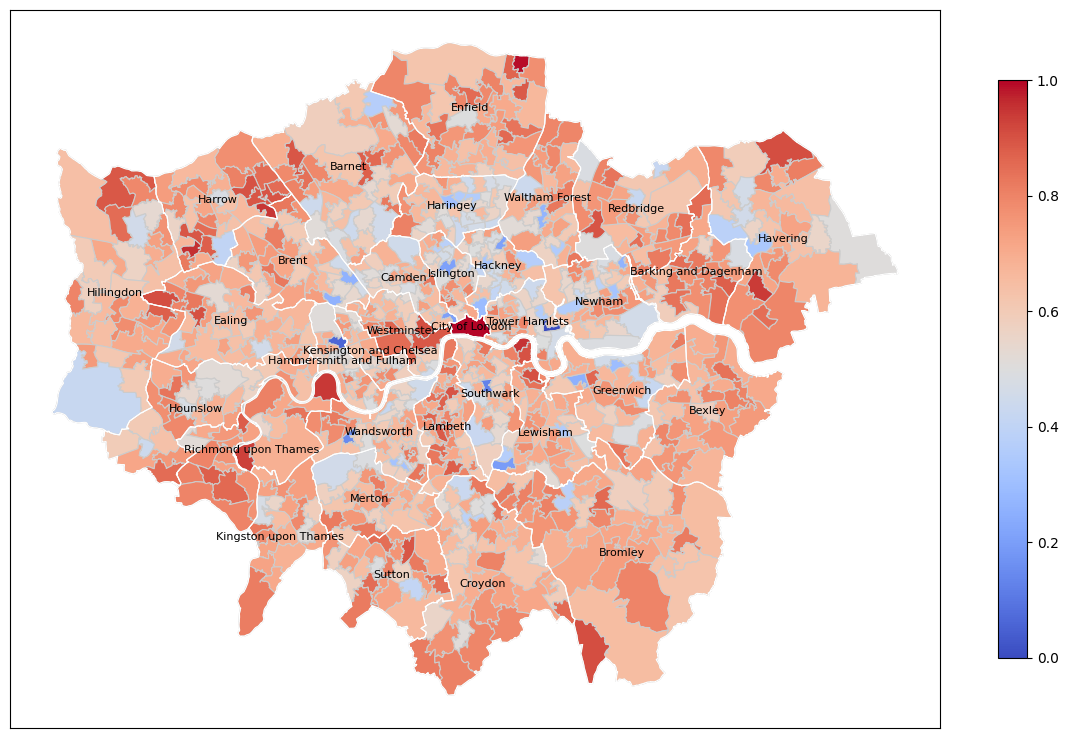

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shp.plot(column='dissimilarity_index_plus_norm', cmap='coolwarm',
                         linewidth=0.8, ax=ax, edgecolor='0.8',
                        legend=True, legend_kwds={'shrink': 0.5})
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
# label each borough with ;'NAME' columne
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')

plt.xticks([])
plt.yticks([])
plt.savefig("output/dissimilarity_index_plus.png", dpi=800)
plt.show()

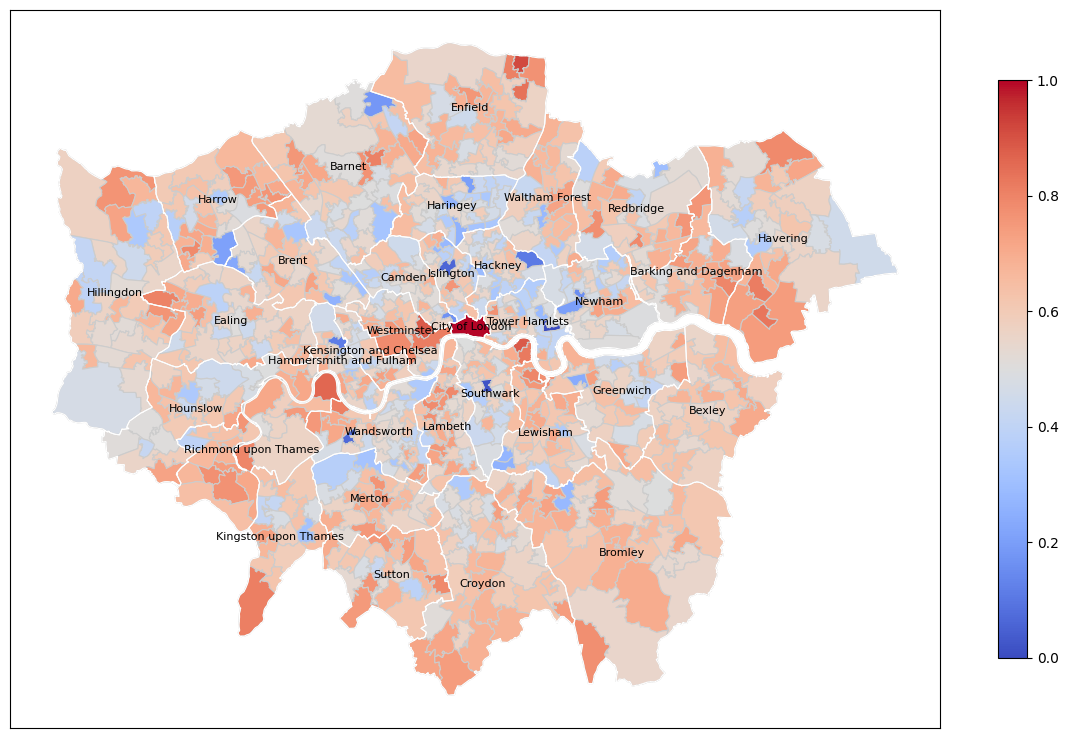

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shp.plot(column='dissimilarity_index_weekday_plus_norm', cmap='coolwarm',
                         linewidth=0.8, ax=ax, edgecolor='0.8',
                        legend=True, legend_kwds={'shrink': 0.5})
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
# label each borough with ;'NAME' columne
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')
    
plt.xticks([])
plt.yticks([])
plt.savefig("output/dissimilarity_index_weekday_plus.png", dpi=800)
plt.show()


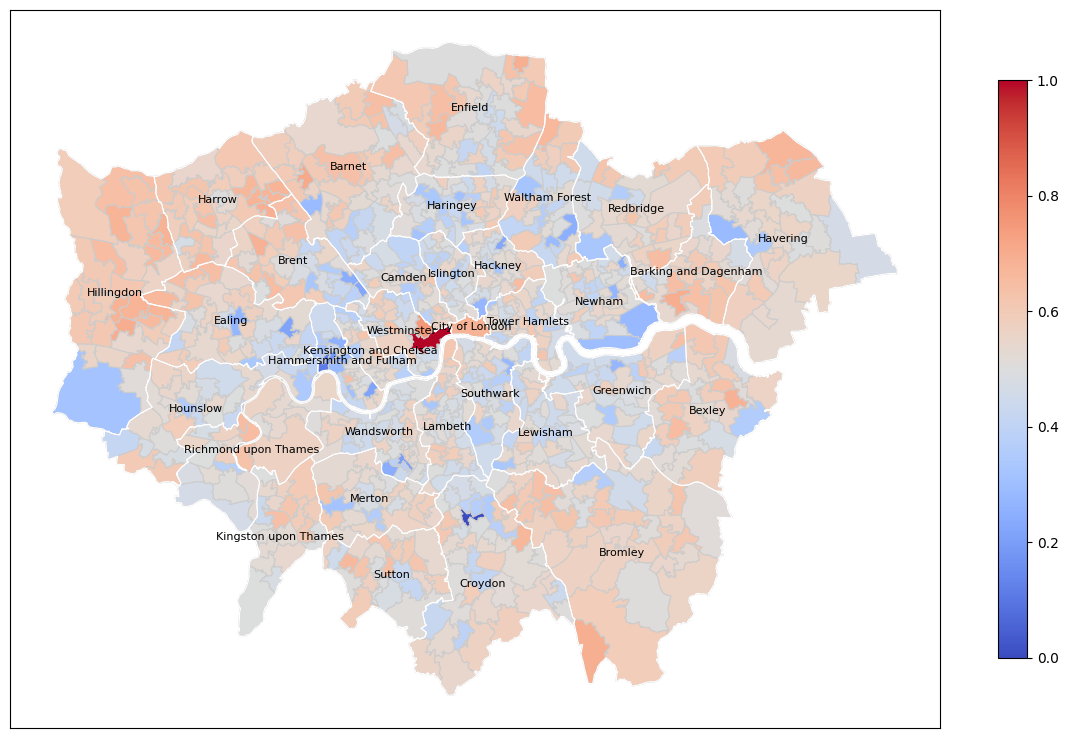

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
msoa_shp.plot(column='dissimilarity_index_weekend_plus_norm', cmap='coolwarm',
                         linewidth=0.8, ax=ax, edgecolor='0.8',
                        legend=True, legend_kwds={'shrink': 0.5})
borough_shp.plot(ax=ax, edgecolor='white', linewidth=0.8, facecolor='none')
for x, y, label in zip(borough_shp.geometry.centroid.x, borough_shp.geometry.centroid.y, borough_shp['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='black')
    
plt.xticks([])
plt.yticks([])
plt.savefig("output/dissimilarity_index_weekend_plus.png", dpi=800)
plt.show()

